In [1]:
import time
from time import sleep
import torch

from comfy import ComfyGenerator
import numpy as nph
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageOps
from autodistill import generate_segmentation, draw_segmentation
import os
import open_clip
from clip import clip_predictions
import os
from ollama import chat
from ollama import ChatResponse

([24.262331008911133, 75.7376708984375], 'unrealistic boat size')


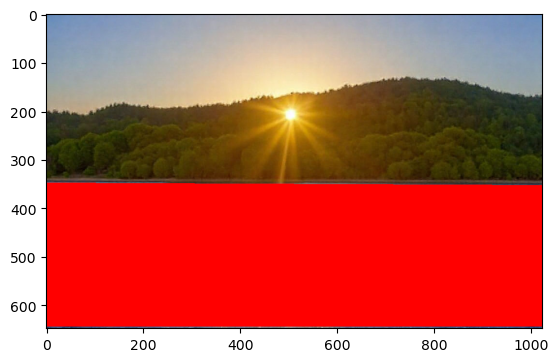

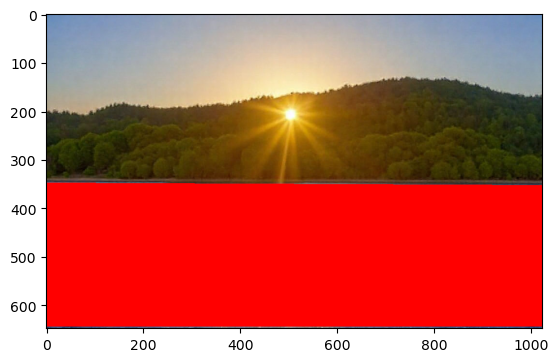

KeyboardInterrupt: 

In [4]:
from datagen import upload_image_to_dataset, upload_annotations_batch
from utils import divide_images_with_masks_and_bboxes, filter_masks_by_polygon, choose_random_elements, plug_annotation
from comfy import create_prompt_for_inpainting
from sam import refine_bounding_box
from ollama_api import answer_question_about_image, answer_question
import uuid
import random

categories = ['Cruise ship', 'Kayak', 'Cargo ship', 'Sailboat', 'Open motorboat', 'Inflatable boat (dinghy)', 'Yatch', 'Fishing vessel']

for image_name in os.listdir("./data"):
    img_url = "./data/" + image_name
    img = Image.open(img_url)
    for number_of_divisions in range(2, 5):
        masks = divide_images_with_masks_and_bboxes(img, n_divisions=number_of_divisions, padding=30)
        segmentation = generate_segmentation(img)["annotations"][0]["data"]["points"]
        filtered_masks = filter_masks_by_polygon(masks, segmentation, threshold=0.75)
        if len(filtered_masks) == 0: continue
        chosen_masks = choose_random_elements(filtered_masks, random.randint(number_of_divisions-1, number_of_divisions))
        current_inpaint = img
        plt.imshow(draw_segmentation(img.copy(), segmentation))
        plt.show()
        bounding_boxes = []
        current_category = choose_random_elements(categories, 1)
        for current_mask, bbox in chosen_masks:
            test_current_inpaint = ComfyGenerator(workflow=create_prompt_for_inpainting(current_inpaint, current_mask, "a single alone " + current_category[0])).generate()[0]
            refined_bbox = refine_bounding_box(test_current_inpaint, bbox)['bounding_boxes'][0]
            crop = test_current_inpaint.crop(bbox)
            clip_predict = clip_predictions(crop, ["{}".format(current_category), "boat", "sea",  "other"])
            if(clip_predict[0][0] < 0.85): continue
            current_inpaint = test_current_inpaint
            bounding_boxes.append(refined_bbox)
        if len(bounding_boxes) == 0: continue
        res = upload_image_to_dataset(current_inpaint, 17)
        image_id = res['id']
        annotations = list(map(lambda x : {"id": str(uuid.uuid4()), "type": "bounding_box", "data": plug_annotation(current_inpaint, x), "label": 7}, bounding_boxes))
        if image_id: upload_annotations_batch(image_id, annotations)



Label probs: tensor([[    0.0000,    99.6101,     0.3899,     0.0000]])
Predicted label:  Inflatable boat (dinghy)


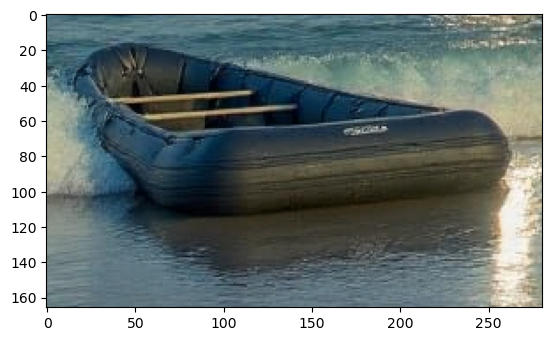

In [19]:

img = current_inpaint.crop(bbox)
plt.imshow(img)
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer("ViT-B-32")

categories = ["forest", current_category[0], "boat", "other"]
img_p = preprocess(img).unsqueeze(0)
text = tokenizer(categories)

with torch.no_grad(), torch.autocast("mps"):
    image_features = model.encode_image(img_p)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

torch.set_printoptions(sci_mode=False)
print("Label probs:", text_probs*100)  # prints: [[1., 0., 0.]]
print("Predicted label: ", categories[text_probs.argmax()])